In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units


from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

rate = 16
if rate == 13:
    from src.ode.dcodes     import ODE
if rate == 16:
    from src.ode.acodes     import ODE

specs, parnt, consv = read_specs_file('C', rate)

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [2]:
## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('-----------------------')
    print('| Input:')
    print('|    ')
    print('|    ρ  =','{:.2E}'.format(ρ))
    print('|    T  =',T)
    print('|    δ  =',δ)
    print('|    Av =',Av)
    print('|    Chem type =', chemtype)
    print('|    Rate      =', rate)
    print('-----------------------')
    print('')

    return ρ, T, δ, Av, chemtype

def solve(ρ, T, δ, Av, chemtype, Δt):

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av, rate)

    Δt = Δt*yr_to_sec  ## in sec


    print(' >> Solving ODE ...')
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n,
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False    ## if True: returns interpolation function
        )

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])

    return ts, ys

def plot(ts, ys):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    for i in range(ys.shape[0]):
        ax1.plot(ts, ys[i])
        ax2.plot(ts, -ys[i])

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ax.set_ylim((1.0e-40, 1.0e+0))

    ax.set_xlabel('time [s]')
    ax1.set_ylabel('abundance')
    ax2.set_ylabel('negative abundance')

    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    idx_neg = list()

    if elwise == False:
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec] < 0):
                idx_neg.append(ispec)

    if elwise == True:
        # print(ys.shape)
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec][el] < 0):
                # print(i,el)
                idx_neg.append(ispec)


    specs_neg = list()

    for idx in idx_neg:
        specs_neg.append(specs[idx])

    return idx_neg, specs_neg

### Test simulations

In [3]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [15]:
## Sim 1
ρ, T, δ, Av, chemtype= setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'O')
ts1, ys1 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE ...


In [ ]:
## Sim 2
ρ, T, δ, Av, chemtype = setinput(1.e-6, 15., 1.e15, 2500., 1., 1., 'O')
ts2, ys2 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 7.51E+05
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [ ]:
## Sim 3
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'C')
ts3, ys3 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [ ]:
## Sim 4
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1.e-5, 0.5, 'O')
ts4, ys4 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1e-05
|    Av = 0.5
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


/tmp/ipykernel_112739/3556290175.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


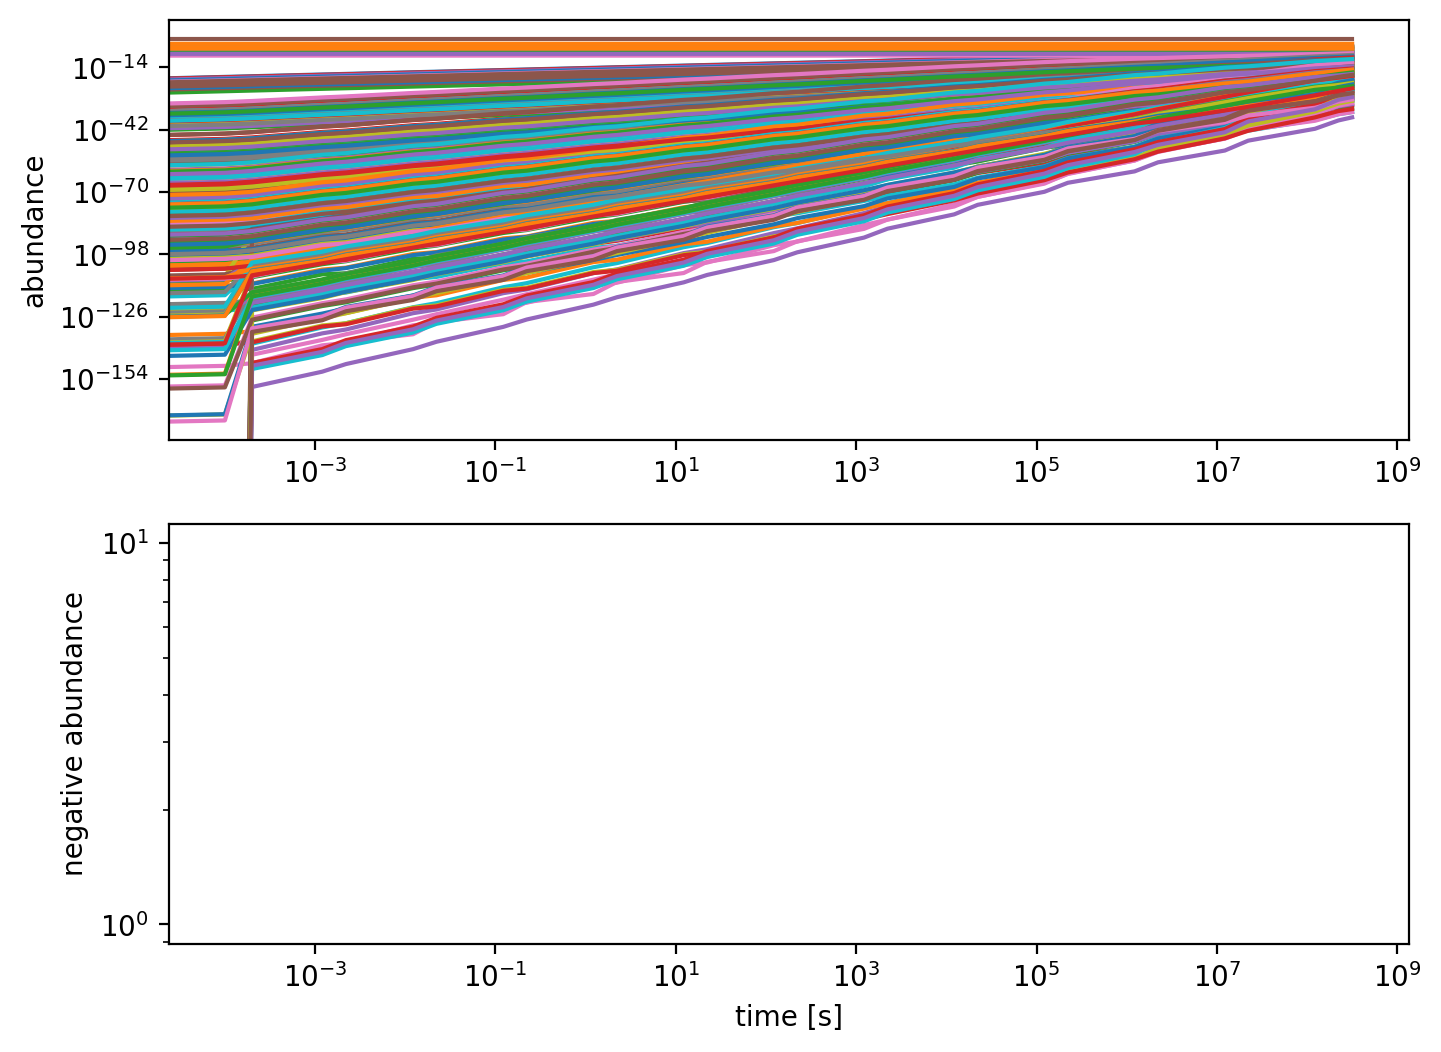

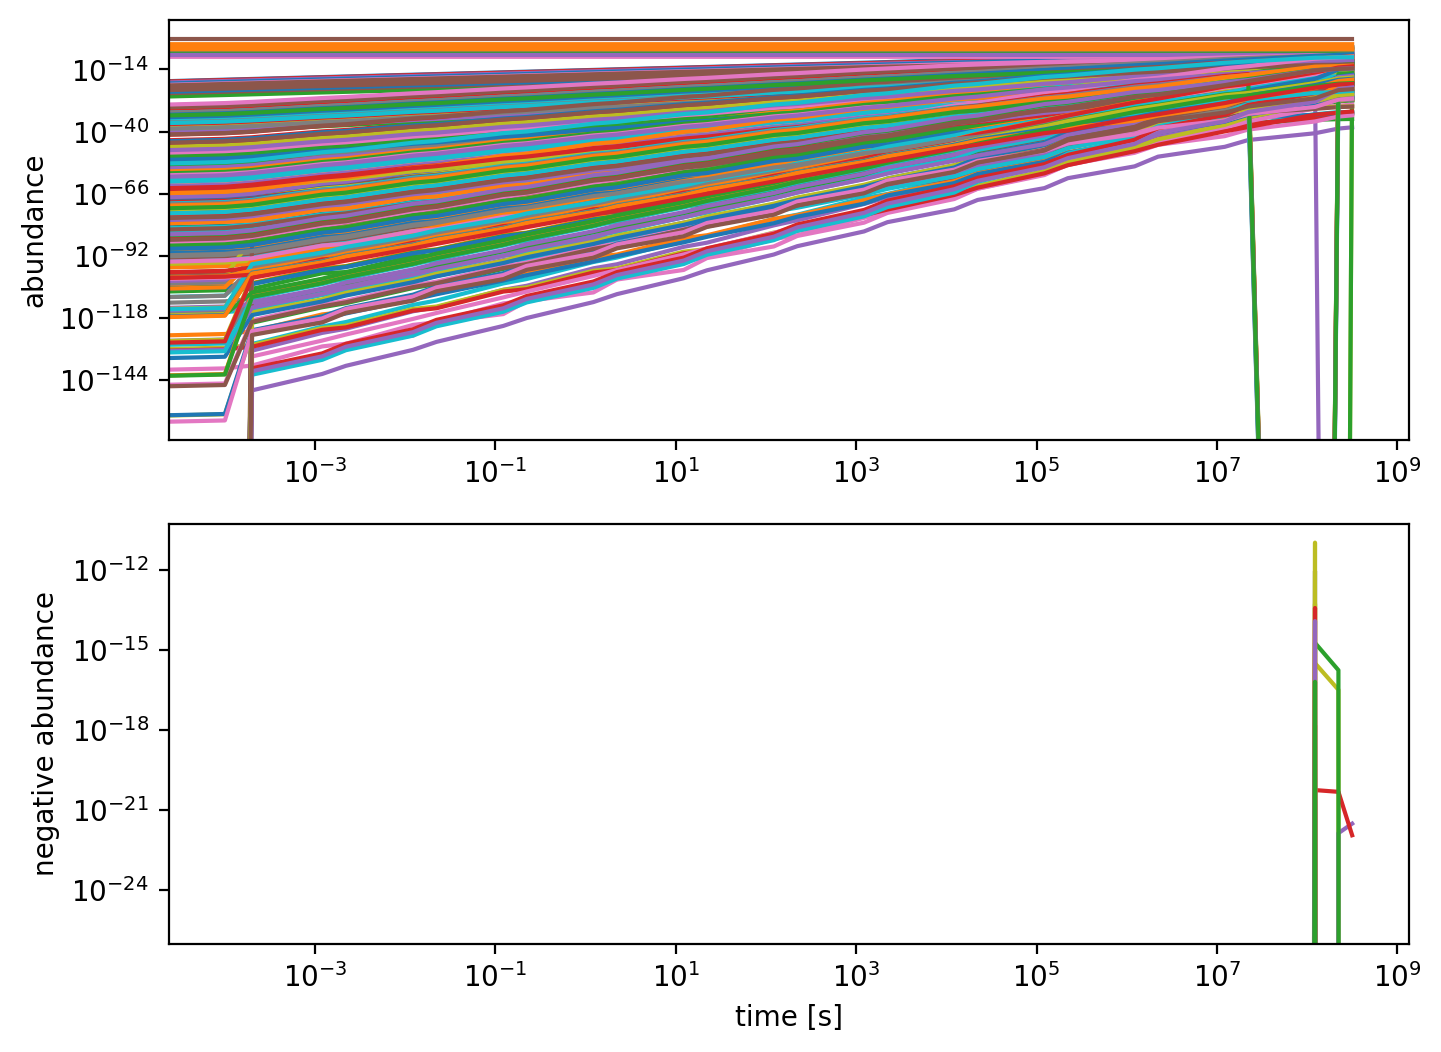

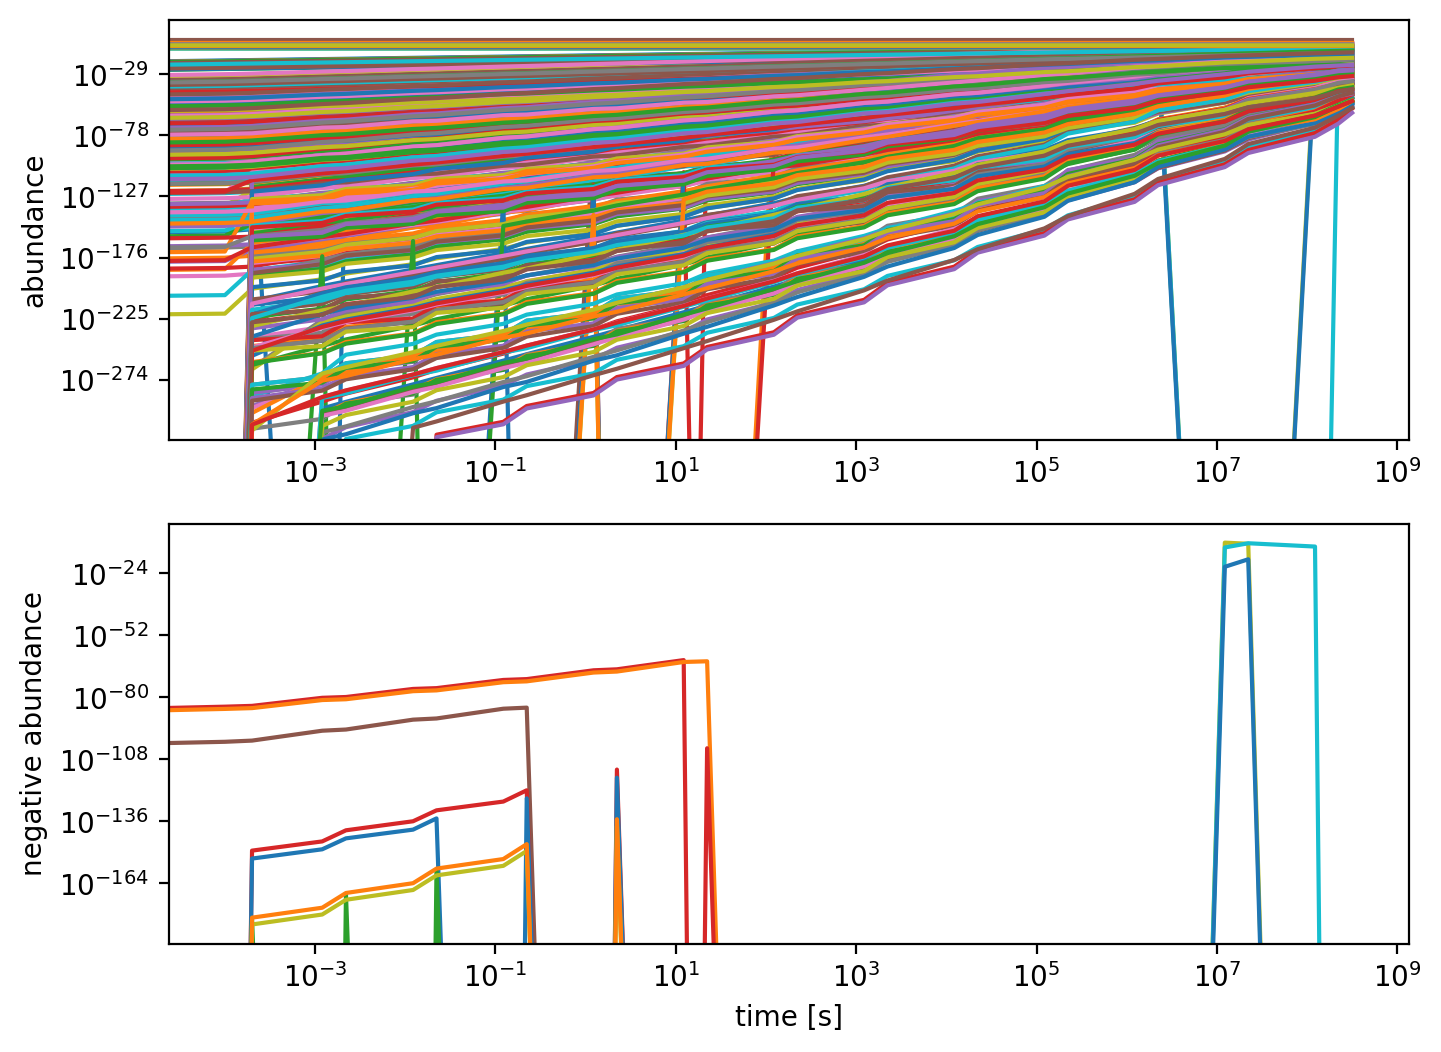

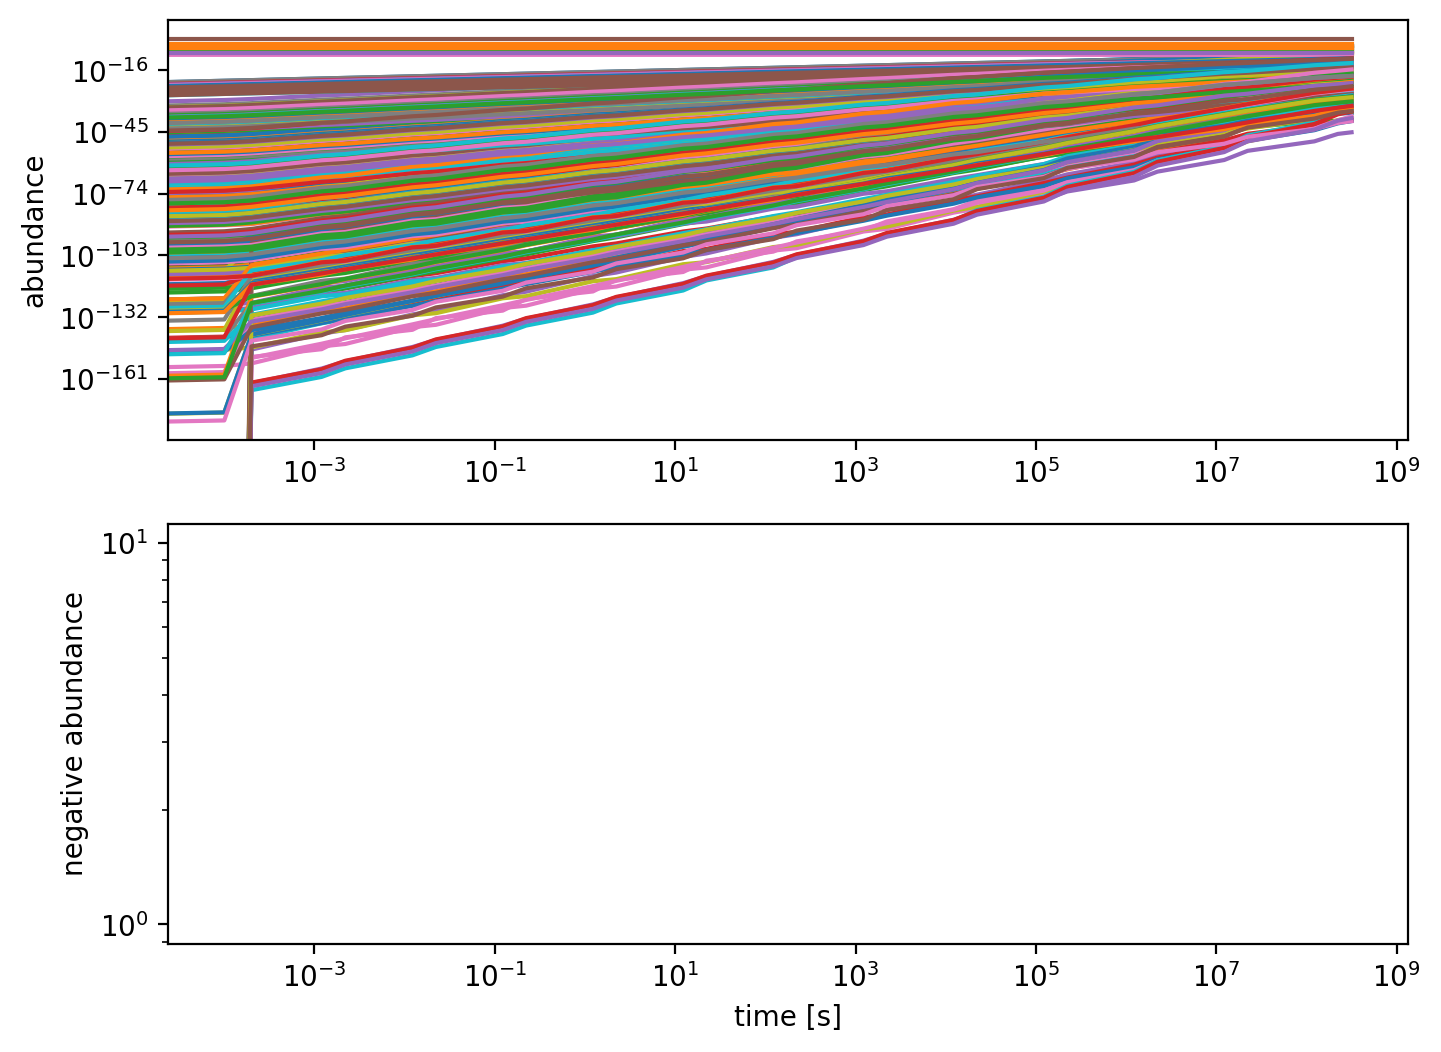

In [ ]:
plot(ts1,ys1)
plot(ts2,ys2)
plot(ts3,ys3)
plot(ts4,ys4)
plt.show()

### Search for negatives

In [14]:
ys = ys3

idx_neg, specs_neg = search_negs(ys)
print('Negative values overal:')
print('#:',len(idx_neg))
print(idx_neg)
print(specs_neg)

print('')

el = 1
for el in range(ys.shape[1]-1):
    idx_neg, specs_neg = search_negs(ys, elwise = True, el=el)
    length = len(idx_neg)
    if el == 1:
        print('Negative values on first position:')
        print('#:',length)
        for i in range(length):
            print(idx_neg[i], specs_neg[i])
    if length != 0:
        print('\nNegative values on position',el)
        print('#:',length)
        print(idx_neg)
        print(specs_neg)

## Where first negative element?


Negative values overal:
#: 11
[38, 73, 75, 81, 129, 130, 353, 370, 392, 398, 401]
['F', 'C2H4', 'C2H5+', 'C2H5', 'Cl', 'Cl+', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on first position:
#: 3
73 C2H4
75 C2H5+
81 C2H5

Negative values on position 1
#: 3
[73, 75, 81]
['C2H4', 'C2H5+', 'C2H5']

Negative values on position 2
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 3
#: 7
[73, 75, 81, 353, 370, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'C4P', 'C4S']

Negative values on position 4
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 5
#: 7
[73, 75, 81, 353, 370, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'C4P', 'C4S']

Negative values on position 6
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 7
#: 6
[

/lhome/silkem/anaconda3/envs/mace/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


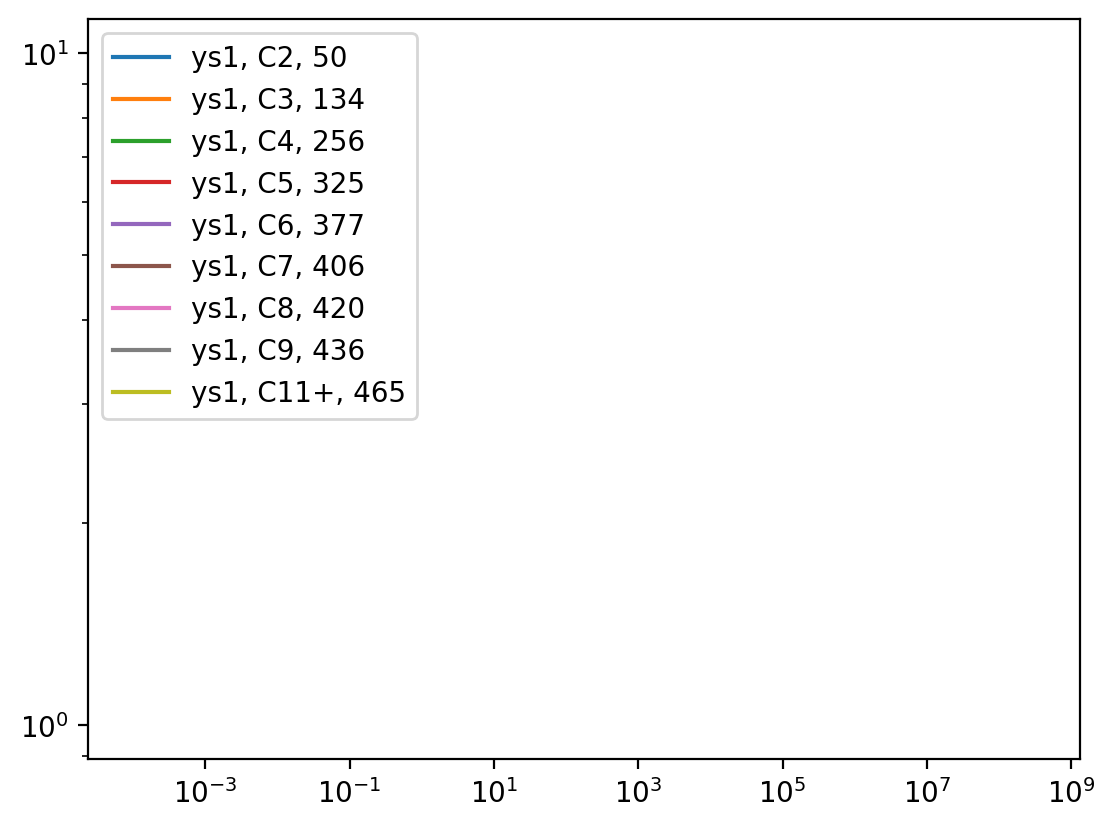

In [10]:
nbs = [50, 134, 256, 325, 377, 406, 420, 436, 465]
# nbs = []
# nbs = [ 441, 439, 465]

for nb in nbs:
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb]+', '+str(nb))
    # plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    # plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    # plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

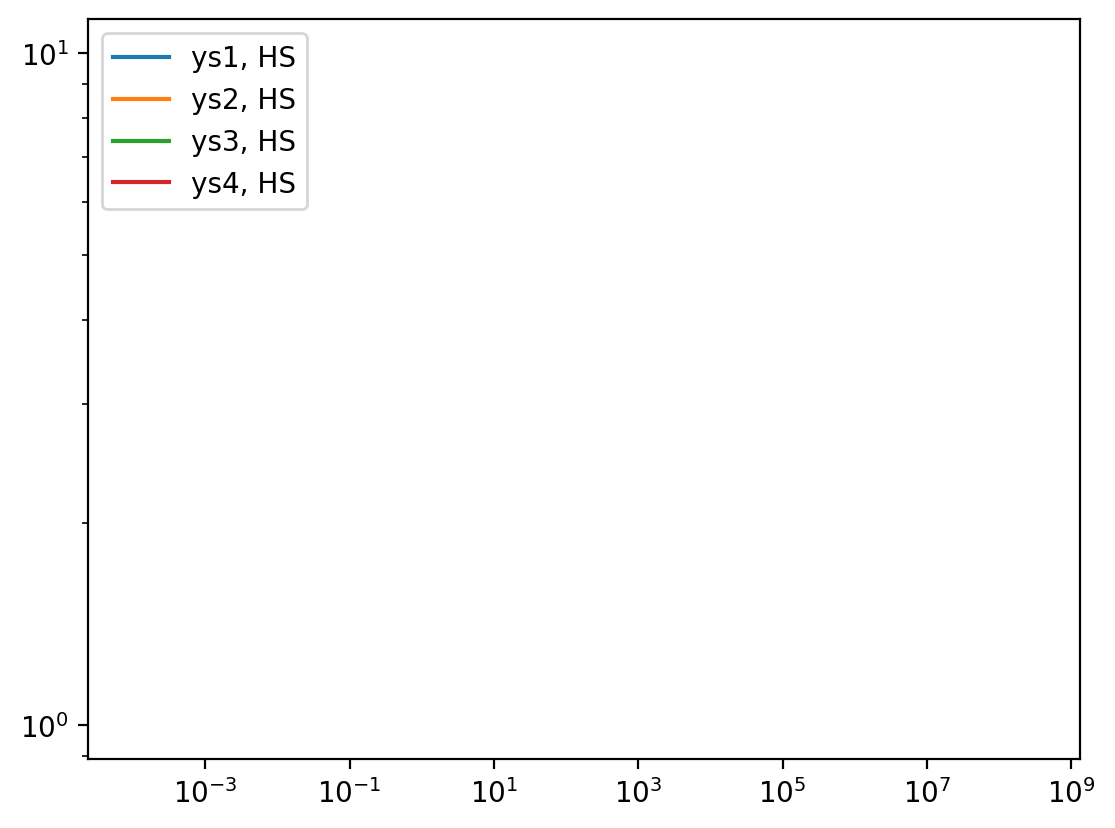

In [11]:
molecs = ['HS']

for molec in molecs:
    nb = specs_dict[molec]
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb])
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

In [12]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [13]:
len(ions)

296